# **Классификация эмоции на изображении лица**

In [1]:
import pandas as pd
import numpy as np
import cv2
import graphviz
import face_recognition as fr
from pathlib import Path

from scipy.ndimage import gaussian_filter
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report  
from sklearn.metrics import confusion_matrix  
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from  matplotlib import pyplot as plt
%matplotlib inline

## **Загрузка изображений**

In [2]:
def get_list_of_files(dir_path):
    """Makes a list of strings of file's paths from directiory"""
    list_of_file = Path.iterdir(dir_path)           
    all_files = []
    for file in list_of_file:
        full_path = dir_path.joinpath(file)
        if Path.is_dir(full_path):
            all_files = all_files + get_list_of_files(full_path)
        else:
            all_files.append(str(full_path))             
    return all_files

In [3]:
project_folder = Path().resolve()
image_folder = project_folder.parent.joinpath('data/raw/images')
# image_folder = r'F:\projects\vs_code\emoji_classification\all'
img_files_list = get_list_of_files(image_folder)
img_files_list

['F:\\projects\\vs_code\\emoji_classification\\emotion_classification\\data\\raw\\images\\S005_001_00000001.png',
 'F:\\projects\\vs_code\\emoji_classification\\emotion_classification\\data\\raw\\images\\S005_001_00000011.png',
 'F:\\projects\\vs_code\\emoji_classification\\emotion_classification\\data\\raw\\images\\S010_001_00000001.png',
 'F:\\projects\\vs_code\\emoji_classification\\emotion_classification\\data\\raw\\images\\S010_002_00000001.png',
 'F:\\projects\\vs_code\\emoji_classification\\emotion_classification\\data\\raw\\images\\S010_002_00000014.png',
 'F:\\projects\\vs_code\\emoji_classification\\emotion_classification\\data\\raw\\images\\S010_003_00000001.png',
 'F:\\projects\\vs_code\\emoji_classification\\emotion_classification\\data\\raw\\images\\S010_004_00000001.png',
 'F:\\projects\\vs_code\\emoji_classification\\emotion_classification\\data\\raw\\images\\S010_004_00000019.png',
 'F:\\projects\\vs_code\\emoji_classification\\emotion_classification\\data\\raw\\images

Прочитаем файл с метками классов

In [4]:
# dic = {
#     0:'neutral',
#     1:'anger',
#     2:'contempt',
#     3:'disgust',
#     4:'fear',
#     5:'happiness',
#     6:'surprise',
# }
df = pd.read_csv('F://projects//vs_code//emoji_classification//label_dataset.csv') 
df = df.drop(columns=['Unnamed: 0'], axis=1)


In [5]:
label_list = []
name_list = []
for i in range(len(img_files_list)):
    pic_name = img_files_list[i].split('\\')[-1]                          
    idx = df[df['file name'] == pic_name].index
    label_list.append(df.at[idx[0], 'label'])
    name_list.append(pic_name)
dic = {'name':name_list,'label':label_list}
df_target = pd.DataFrame(dic)
df_target.to_csv() 
df_target

,name,label
0,S005_001_00000001.png,0
1,S005_001_00000011.png,3
2,S010_001_00000001.png,0
3,S010_002_00000001.png,0
4,S010_002_00000014.png,6
...,...,...
915,S895_002_00000007.png,2
916,S999_001_00000001.png,0
917,S999_001_00000018.png,1
918,S999_003_00000001.png,0


In [6]:
def find_picture(name_pic):
    for val in img_files_list:
        if name_pic == val.split('\\')[-1]:
            return val

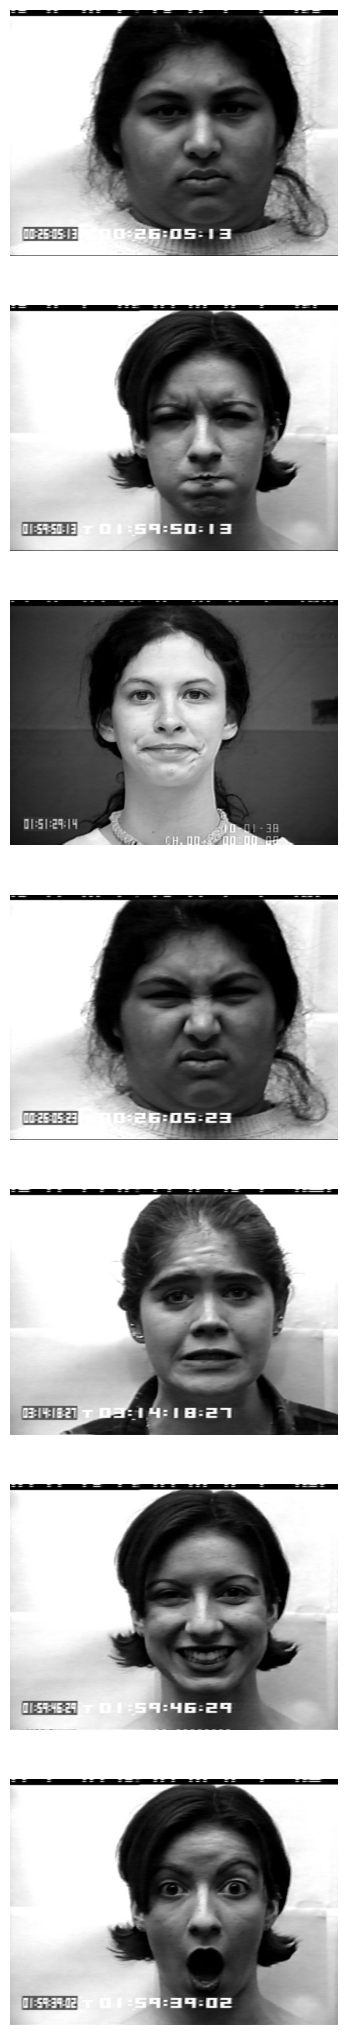

In [7]:
res_gr = df.groupby('label')['file name'].apply(list)
plt.figure(figsize=(30,30))
for i in range(res_gr.shape[0]):
    path = find_picture(res_gr[i][0])
    image = cv2.imread(path)
    plt.subplot(res_gr.shape[0]+ 1, 1, i + 1)
    plt.imshow(image)
    plt.axis('off')
    

## Предобработка изображений

In [8]:
def image_pre_processing(data, sigma_GF, IMG_HEIGHT, IMG_WIDTH):
    """Applies Gaussian filter to remove noise, applies histogram 
    equalisation and scales image to convert all data to a common format"""
    X = []
    for path in data:
        image = cv2.imread(str(path))

        image_GF = cv2.GaussianBlur(image, (5, 5), sigma_GF)    # Gaussian filter

        face_loc = fr.face_locations(img = image_GF, model='hog')   # Face detection and crop
        if len(face_loc) > 1:
          face_loc=[(face_loc[0])]
        top, right, bottom, left = face_loc[0]
        image_CROPPED = image_GF[top:bottom, left:right]

        clahe = cv2.createCLAHE(clipLimit=3, tileGridSize=(8, 8))   # Histogram equalization
        lab = cv2.cvtColor(image_CROPPED, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(lab)
        l2 = clahe.apply(l)
        lab = cv2.merge((l2,a,b))
        img_clahe = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
        img_clahe = cv2.cvtColor(img_clahe, cv2.COLOR_BGR2GRAY)

        image_SCALED = cv2.resize(img_clahe, (IMG_HEIGHT, IMG_WIDTH))
        X.append(image_SCALED)

    X = np.array(X)
    return X 

Визуализируем применение фильтра Гаусса к одному изображению (до/после)

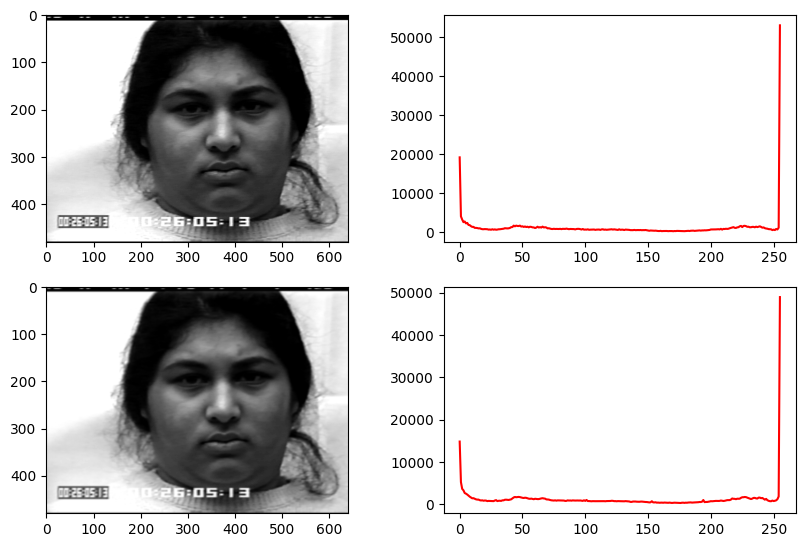

In [9]:
image = cv2.imread(img_files_list[0])
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
sigma_GF = 1
plt.figure(figsize=(10, 10))
plt.subplot(3, 2, 1)
plt.imshow(image, cmap='gray')

hist1 = cv2.calcHist([image], [0], None, [256], [0, 256])
plt.subplot(3, 2, 2)
plt.plot(hist1, color='red')

image_GF = cv2.GaussianBlur(image, (5, 5), 1)
plt.subplot(3, 2, 3)
plt.imshow(image_GF, cmap='gray')

hist2 = cv2.calcHist([image_GF], [0], None, [256], [0, 256])
plt.subplot(3, 2, 4)
plt.plot(hist2, color='red')


Визуализируем применения эквилизации гистограммы к одному изображению (до/после)

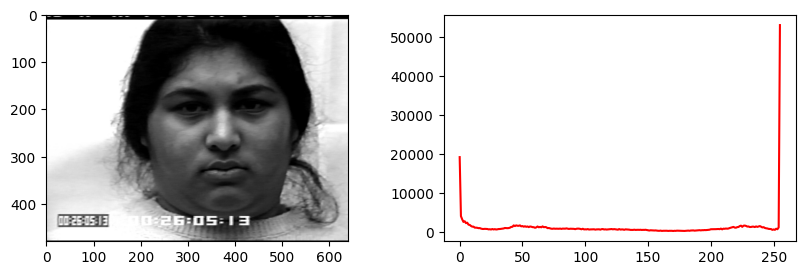

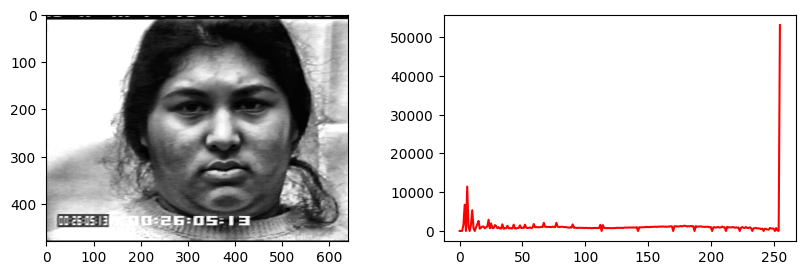

In [10]:
img = cv2.imread(img_files_list[0])

sigma_GF = 1
img = cv2.circle(img, (205, 526), radius=1, color=(0, 0, 255), thickness=10)
plt.figure(figsize=(10, 10))
plt.subplot(3, 2, 1)
plt.imshow(img)

hist1 = cv2.calcHist([image], [0], None, [256], [0, 256])
plt.subplot(3, 2, 2)
plt.plot(hist1, color='red')

clahe = cv2.createCLAHE(clipLimit=3, tileGridSize=(8, 8))
lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
l, a, b = cv2.split(lab)
l2 = clahe.apply(l)
lab = cv2.merge((l2,a,b))
img_clahe = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
img_clahe = cv2.cvtColor(img_clahe, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(10, 10))
plt.subplot(3, 2, 3)
plt.imshow(img_clahe, cmap='gray')

hist2 = cv2.calcHist([img_clahe], [0], None, [256], [0, 256])
plt.subplot(3, 2, 4)
plt.plot(hist2, color='red')

## **Извлечение признаков с фильтрами Габбора**


In [11]:
theta_range = np.arange(0, np.pi, np.pi/8) # Ориентация 
lamda = 4* np.pi/4 # Длина волны синуса
gamma = 0.5 # Пространственное соотношение сторон
sigma = 1 # Стандартное отклонение гаусса
ksize = 9 # Размер фильтра
phi = 0 # Фаза

def GaborFiltersFeatures(ksize, sigma, theta_range, lamda, gamma, phi):
    # Создаем фильтр
    filters = []
    for theta in theta_range:
            kern = cv2.getGaborKernel(
                (ksize, ksize), sigma, theta, lamda,
                gamma, phi, ktype=cv2.CV_64F
            )
            kern /= 1.0 * kern.sum()
            filters.append(kern)
    return filters

def apply_filter(processed_path_list, filters):
    res = []
    depth = -1
    for img_path in processed_path_list:
        img = cv2.imread(str(img_path))
        newimage = np.zeros_like(img)
        flat_ar = []
        for kern in filters:
            image_filter = cv2.filter2D(img, depth, kern)
            np.maximum(newimage, image_filter, newimage)
            flat_ar.append(np.array(newimage))
        flat_ar.append(np.array(img))
        res.append(np.array(flat_ar).flatten())

    res = np.array(res)
    return res

In [12]:
filters = GaborFiltersFeatures(ksize, sigma, theta_range, lamda, gamma, phi)
len(filters)

8

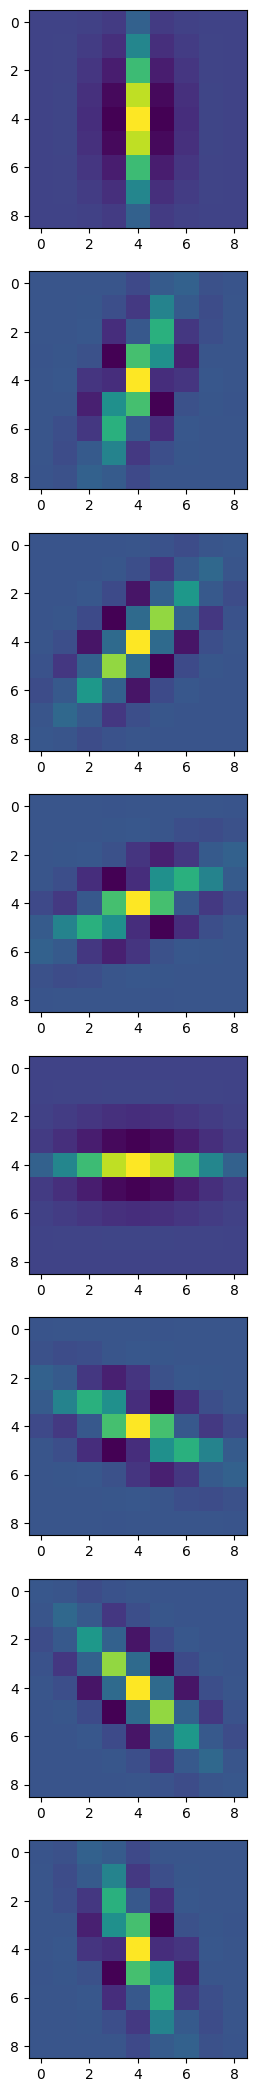

In [13]:
# напишите код для визуализации фильтров Габора с
plt.figure(figsize=(30, 30))
for i, filt in enumerate(filters):
    plt.subplot(len(filt), 1, i + 1)
    plt.imshow(filt)

Применим фильтры Габора к любому изображению из датасета

In [14]:
X_processed = get_list_of_files(project_folder.parent.joinpath('data/processed/images'))

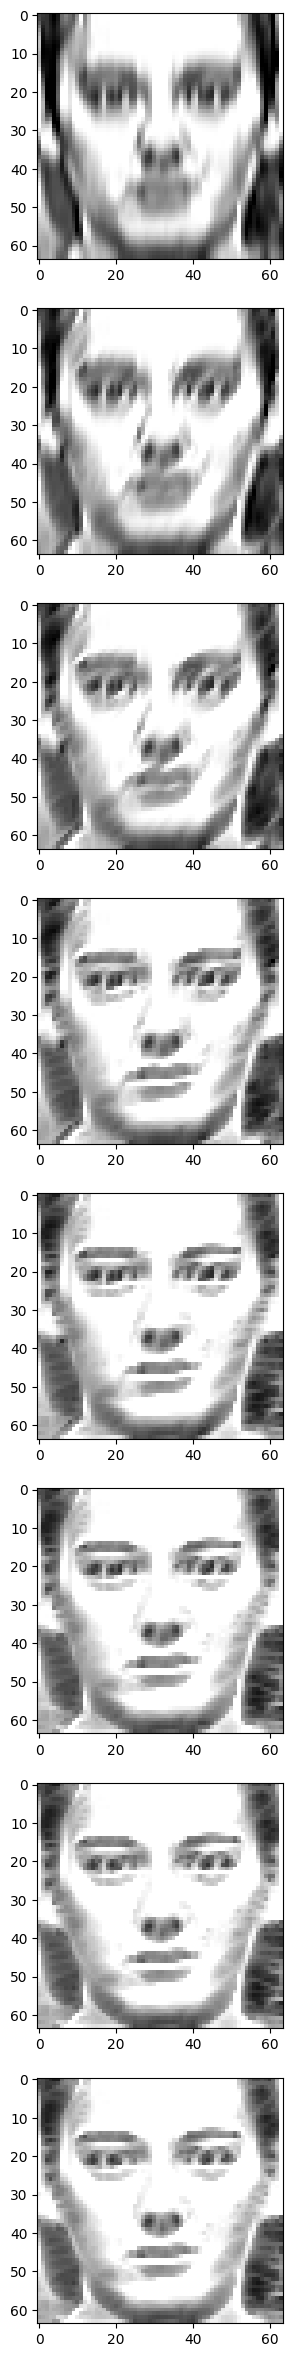

In [15]:
plt.figure(figsize=(30, 30))
image_g = []
depth = -1
img = cv2.imread(str(X_processed[77]))
newimage = np.zeros_like(img)
for kern in filters:
    image_filter = cv2.filter2D(img, depth, kern)
    np.maximum(newimage, image_filter, newimage)
    image_g.append(np.array(newimage))

image_g = np.array(image_g)
for i, img in enumerate(image_g):
    plt.subplot(image_g.shape[0], 1, i + 1)
    plt.imshow(img, cmap='gray')

## **Применение снижения размерности**
* PCA and LDA

In [16]:
X_processed = get_list_of_files(project_folder.parent.joinpath('data/processed/images'))

In [17]:
X_featured = apply_filter(X_processed, filters)
X_featured.shape

(920, 110592)

In [18]:
scaler = StandardScaler()
scaler.fit(X_featured)
X_scaled = scaler.transform(X_featured)
X_scaled[0], X_scaled.shape

(array([-0.12856205, -0.12856205, -0.12856205, ...,  0.35458878,
         0.35458878,  0.35458878]),
 (920, 110592))

In [19]:
pca = PCA(0.95)
pca.fit(X_scaled)
ratio = pca.explained_variance_ratio_

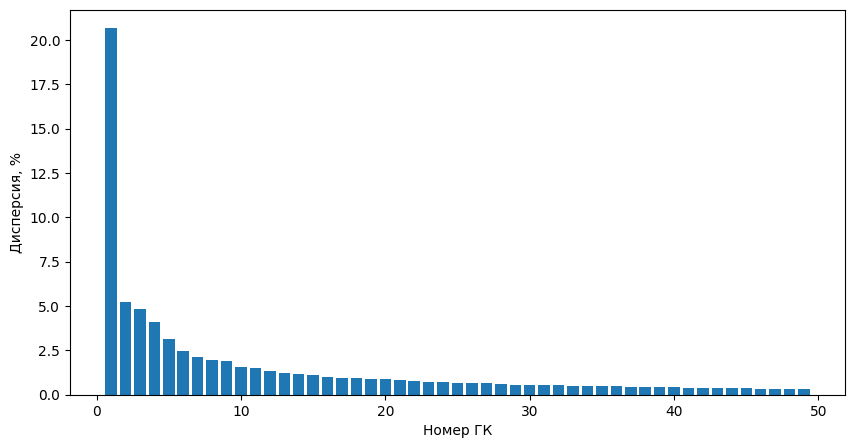

In [20]:
# Оценим вклад ГК
fig = plt.figure(figsize = (10, 5))
plt.xlabel("Номер ГК")
plt.ylabel("Дисперсия, %")
plt.bar(range(1, 50),ratio[:49] *100)
plt.show()

In [21]:
summ = 0
i = 0
while summ < 95:
    summ += ratio[i] * 100
    i +=1
num_mc = i - 1
summ, num_mc

(95.00294401959651, 287)

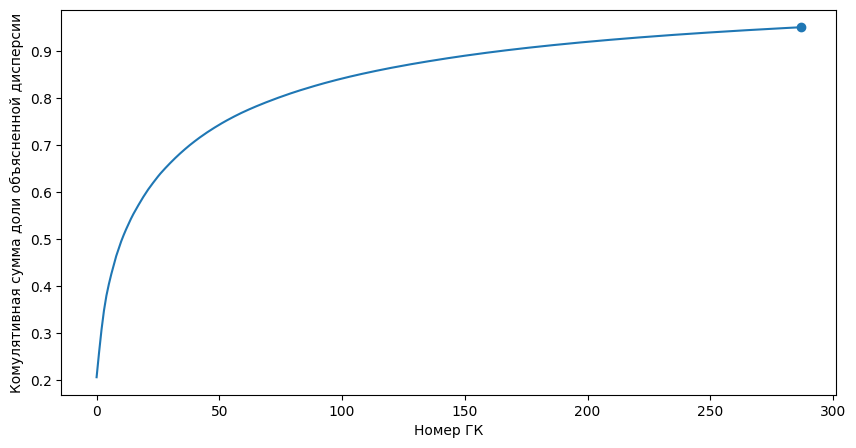

In [22]:
cum_sum = np.cumsum(ratio)
fig = plt.figure(figsize = (10, 5)) 
plt.xlabel("Номер ГК") 
plt.ylabel("Комулятивная сумма доли объясненной дисперсии") 
plt.plot(cum_sum[:]) 
plt.scatter(num_mc, cum_sum[num_mc]) 
plt.show()

# Многоклассовая классификация различными методами

Снизим размерность признаков с помощью PCA + LDA. Далее произведем классификацию следующими методами:
* Decidion Tree
* Random Forest
* AdaBoost
* GradientBoost
* k-NN
* SVM
* NB

Сформируем тестовую и тренировочную выборки:

In [23]:
y = np.array(df_target.label)
X_train, X_test, y_train, y_test = train_test_split(X_featured, y,
                                                    test_size=0.2)

In [24]:
labeled_df = pd.DataFrame(data=X_train)
labeled_df['label'] = y_train

In [25]:
y = np.array(labeled_df.label)
np.unique(y, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6], dtype=int64),
 array([492,  35,  17,  44,  20,  56,  72], dtype=int64))

Видно, что выборка неравномерная, нейтральной эмоции намного больше остальных. Сделаем upsampling в 3 раза других классов. Ресемплинг делаем только для трейн, чтобы во время тестирования не попадалось одинаковых изображений.

In [26]:
upsample = pd.DataFrame(np.repeat(
        labeled_df[labeled_df.label != 0].values, 3, axis=0))
upsample.columns = labeled_df.columns
resampled_df = pd.concat([labeled_df[labeled_df.label == 0], upsample], ignore_index=True)
resampled_df = resampled_df.reset_index(drop=True)
resampled_df.label.value_counts()

0    492
6    216
5    168
3    132
1    105
4     60
2     51
Name: label, dtype: int64

In [27]:
y_train = resampled_df.label
X_train = resampled_df.drop('label', axis=1)

In [28]:
np.unique(y_test, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6], dtype=int64),
 array([129,  10,   1,  15,   5,  13,  11], dtype=int64))

### **Уменьшение размерности с помощью PCA**

In [29]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
pca = PCA(0.95)
x_train_pca = pca.fit(X_train_scaled).transform(X_train_scaled)
x_train_pca = pd.DataFrame(data=x_train_pca)

In [30]:
scaler = StandardScaler()
scaler.fit(X_test)
X_test_scaled = scaler.transform(X_test)
x_test_pca = pca.transform(X_test_scaled)
x_test_pca = pd.DataFrame(data=x_test_pca)

## **Классификация с помощью LDA**

In [31]:
LDA_model = LinearDiscriminantAnalysis()
LDA_model.fit(x_train_pca, y_train)
LDA_prediction = LDA_model.predict(x_test_pca)

In [32]:
LDA_train_accuracy = LDA_model.score(x_train_pca, y_train)
LDA_test_accuracy = LDA_model.score(x_test_pca, y_test)
conf_matrix = confusion_matrix(LDA_prediction, y_test)
report = classification_report(y_test, LDA_model.predict(x_test_pca),
                                output_dict=True)
df_report = pd.DataFrame(report).transpose()

Точность модели на обучающей выборке:  0.99
Точность модели на тестовой выборке:  0.8
Матрица несоответствий метода "Линейный дискриминантный анализ без МГК":



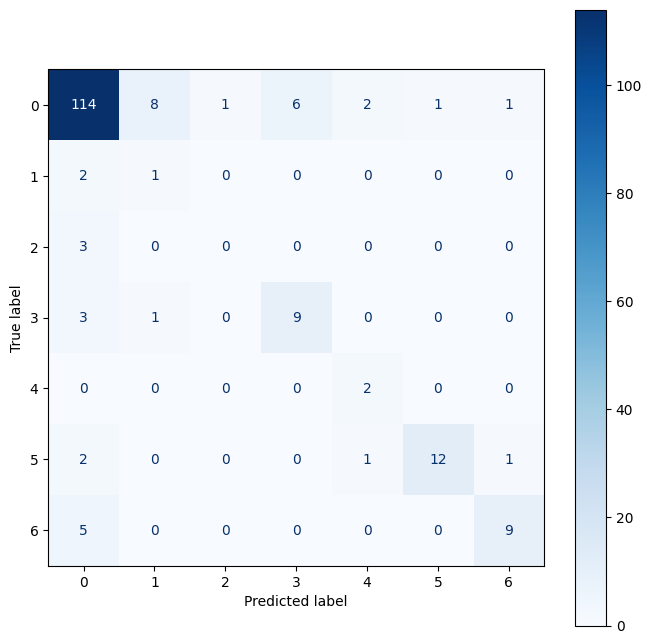

In [33]:
print ('Точность модели на обучающей выборке: ', round (LDA_train_accuracy, 2))
print ('Точность модели на тестовой выборке: ', round (LDA_test_accuracy, 2))
print('Матрица несоответствий метода "Линейный дискриминантный анализ без МГК":\n')

fig, ax = plt.subplots(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix(LDA_prediction, y_test))
disp.plot(cmap = 'Blues', ax=ax);

Из матрицы несоответсвий видно, что нейтральной эмоции (нулевой) в тестовой выборке больше остальных классов, поэтому точность не является показательной метрикой. Качество предсказания модели лучше всего отображают метрики f1-score, macro и weighted avarage. Они учитывают precision и recall вместе.

In [34]:
report = classification_report(y_test, LDA_model.predict(x_test_pca), output_dict=True)
df = pd.DataFrame(report).transpose()
df

,precision,recall,f1-score,support
0,0.857143,0.883721,0.870229,129.000000
1,0.333333,0.100000,0.153846,10.000000
2,0.000000,0.000000,0.000000,1.000000
3,0.692308,0.600000,0.642857,15.000000
4,1.000000,0.400000,0.571429,5.000000
5,0.750000,0.923077,0.827586,13.000000
6,0.642857,0.818182,0.720000,11.000000
accuracy,0.798913,0.798913,0.798913,0.798913
macro avg,0.610806,0.532140,0.540850,184.000000
weighted avg,0.794080,0.798913,0.787916,184.000000


Уменьшим размерность с помощью LDA и запишем результат

In [35]:
x_train_lda = LDA_model.transform(x_train_pca)
x_train_lda = pd.DataFrame(data=x_train_lda)
x_train_lda.shape

(1224, 6)

In [36]:
x_test_lda = LDA_model.transform(x_test_pca)
x_test_lda = pd.DataFrame(data=x_test_lda)
x_test_lda.shape

(184, 6)

##  Decision Tree

В последующих классификаторах будем использвовать Grid Search для подбора наилучших параметров модели

In [94]:
clf = tree.DecisionTreeClassifier()
#Подбор лучших параметров:
params = {'criterion':['gini', 'entropy', 'log_loss'],
           'max_depth':range(2, 10), 'min_samples_split':range(2, 6),
            'min_samples_leaf':range(2, 10)}
search = GridSearchCV(clf, params, scoring="f1_weighted", cv=5)
search.fit(x_train_lda, y_train)
search.best_params_

{'criterion': 'gini',
 'max_depth': 7,
 'min_samples_leaf': 3,
 'min_samples_split': 3}

Сохраним дерево с помощью graphiz

In [95]:
best_tree = search.best_estimator_
dot_data = tree.export_graphviz(best_tree, out_file='tree.dot',  
                                class_names=[
                                    'Neutral','Anger', 'contempt', 'Disgust',
                                    'Fear', 'Happiness', 'Surprise'],
                                filled=True, rounded=True,  
                                special_characters=True)  
# graph = graphviz.Source(dot_data)  
# # graph.render("best_tree", view=True)
# # graph
# doctest_mark_exe()

In [96]:
train_accuracy = best_tree.score(x_train_lda, y_train)
test_accuracy = best_tree.score(x_test_lda, y_test)
print ('Точность модели на обучающей выборке: ', round (train_accuracy, 3))
print ('Точность модели на тестовой выборке: ', round (test_accuracy, 3))

Точность модели на обучающей выборке:  0.984
Точность модели на тестовой выборке:  0.777


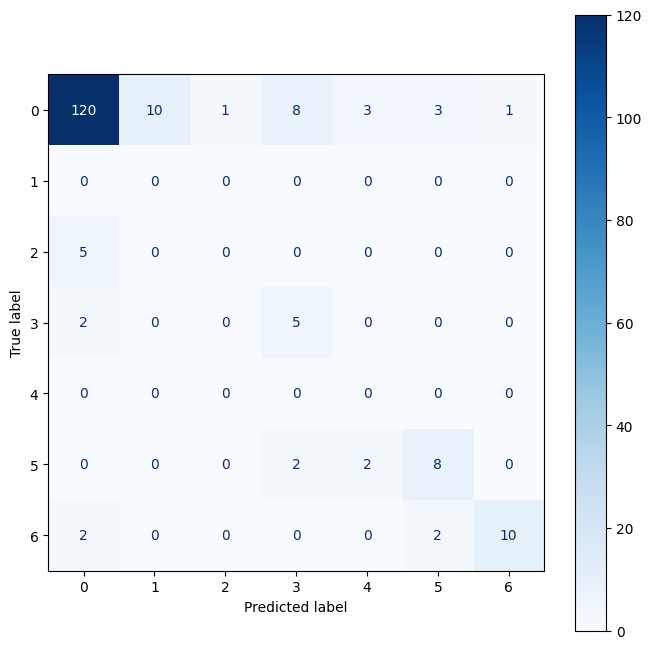

In [97]:
tree_prediction = best_tree.predict(x_test_lda)

fig, ax = plt.subplots(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix(tree_prediction, y_test))
disp.plot(cmap = 'Blues', ax=ax);

clasification report

In [98]:
print (classification_report(y_test, best_tree.predict(x_test_lda)))

              precision    recall  f1-score   support

           0       0.82      0.93      0.87       129
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00         1
           3       0.71      0.33      0.45        15
           4       0.00      0.00      0.00         5
           5       0.67      0.62      0.64        13
           6       0.71      0.91      0.80        11

    accuracy                           0.78       184
   macro avg       0.42      0.40      0.40       184
weighted avg       0.72      0.78      0.74       184



f:\Anaconda\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
f:\Anaconda\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
f:\Anaconda\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Сравним работу классификатора на данных без применения LDA, только после PCA.

In [42]:
clf_pca = tree.DecisionTreeClassifier()
params = {'criterion':['gini', 'entropy', 'log_loss'],
           'max_depth':range(2, 10), 'min_samples_split':range(2, 6),
            'min_samples_leaf':range(2, 10)}
search = GridSearchCV(clf_pca, params, cv=5, n_jobs=-1)
search.fit(x_train_pca, y_train)
search.best_params_

{'criterion': 'gini',
 'max_depth': 4,
 'min_samples_leaf': 7,
 'min_samples_split': 4}

In [43]:
best_tree_pca = search.best_estimator_

In [44]:
train_accuracy = best_tree_pca.score(x_train_pca, y_train)
test_accuracy = best_tree_pca.score(x_test_pca, y_test)
print ('Точность модели на обучающей выборке: ', round (train_accuracy, 3))
print ('Точность модели на тестовой выборке: ', round (test_accuracy, 3))

Точность модели на обучающей выборке:  0.612
Точность модели на тестовой выборке:  0.63


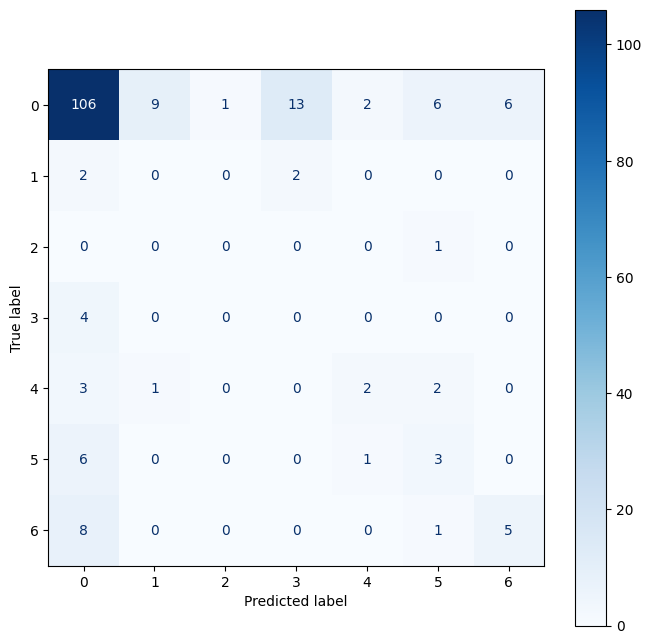

In [45]:
tree_prediction = best_tree_pca.predict(x_test_pca)
conf_matrix = confusion_matrix(tree_prediction, y_test)

fig, ax = plt.subplots(figsize=(8, 8))
disp = ConfusionMatrixDisplay(conf_matrix)
disp.plot(cmap = 'Blues', ax=ax);

In [46]:
print (classification_report(y_test, best_tree_pca.predict(x_test_pca)))

              precision    recall  f1-score   support

           0       0.74      0.82      0.78       129
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00        15
           4       0.25      0.40      0.31         5
           5       0.30      0.23      0.26        13
           6       0.36      0.45      0.40        11

    accuracy                           0.63       184
   macro avg       0.24      0.27      0.25       184
weighted avg       0.57      0.63      0.60       184



Точность модели сильно ухудшилась и скорость "обучения" сильно увеличилась, поэтому далее будем использовать данные с применением PCA + LDA

## Random Forest

In [103]:
clf = RandomForestClassifier(random_state=17)
params = {'n_estimators': range(13, 20), 'max_depth' : range(3, 10), 
     'min_samples_split' : range(2, 7),
     'min_samples_leaf': range(1, 5)}
search = GridSearchCV(clf, params,  scoring="f1_weighted", cv=5, n_jobs=-1)
search.fit(x_train_lda, y_train)
search.best_params_

{'max_depth': 5,
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 14}

In [104]:
clf_best_rf = search.best_estimator_
clf_best_rf.fit(x_train_lda, y_train)

RandomForestClassifier(max_depth=5, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=14, random_state=17)

In [105]:
train_accuracy_rf = clf_best_rf.score(x_train_lda, y_train)
test_accuracy_rf = clf_best_rf.score(x_test_lda, y_test)
print ('Точность модели на обучающей выборке: ', round (train_accuracy_rf, 2))
print ('Точность модели на тестовой выборке: ', round (test_accuracy_rf, 2))

Точность модели на обучающей выборке:  0.98
Точность модели на тестовой выборке:  0.8


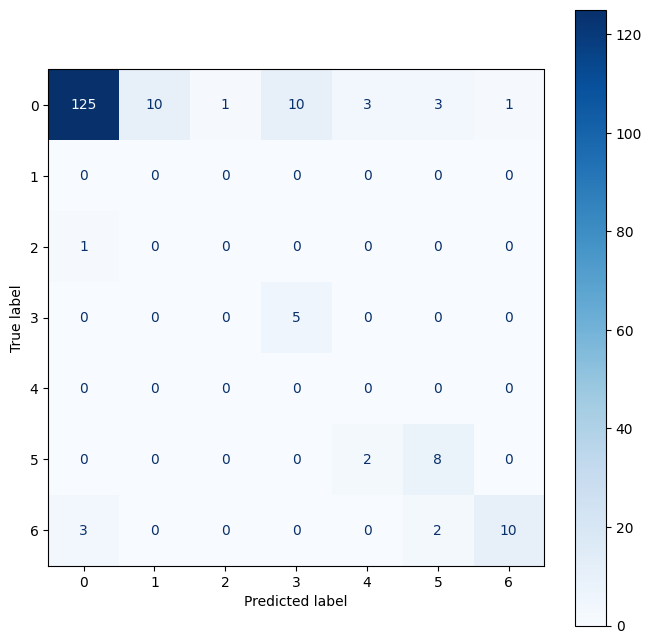

In [106]:
rf_prediction = clf_best_rf.predict(x_test_lda)
conf_matrix = confusion_matrix(rf_prediction, y_test)

fig, ax = plt.subplots(figsize=(8, 8))
disp = ConfusionMatrixDisplay(conf_matrix)
disp.plot(cmap = 'Blues', ax=ax);

clasification report

In [107]:
print ('\n clasification report:\n', classification_report(y_test, clf_best_rf.predict(x_test_lda)))


 clasification report:
               precision    recall  f1-score   support

           0       0.82      0.97      0.89       129
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00         1
           3       1.00      0.33      0.50        15
           4       0.00      0.00      0.00         5
           5       0.80      0.62      0.70        13
           6       0.67      0.91      0.77        11

    accuracy                           0.80       184
   macro avg       0.47      0.40      0.41       184
weighted avg       0.75      0.80      0.76       184



f:\Anaconda\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
f:\Anaconda\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
f:\Anaconda\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Ada boost

In [99]:
bdt = AdaBoostClassifier(best_tree)
bdt.fit(x_train_lda, y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=7,
                                                    min_samples_leaf=3,
                                                    min_samples_split=3))

In [100]:
train_accuracy_rf = bdt.score(x_train_lda, y_train)
test_accuracy_rf = bdt.score(x_test_lda, y_test)
print ('Точнос`ть модели на обучающей выборке: ', round (train_accuracy_rf, 2))
print ('Точность модели на тестовой выборке: ', round (test_accuracy_rf, 2))

Точнос`ть модели на обучающей выборке:  1.0
Точность модели на тестовой выборке:  0.8


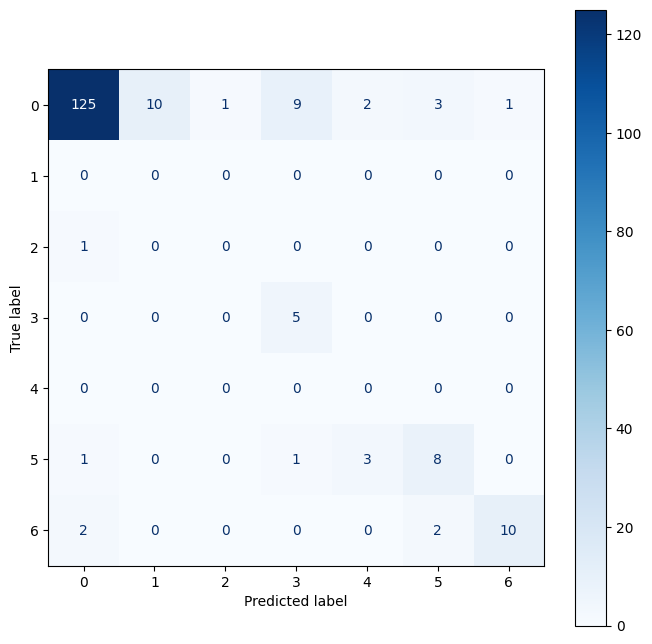

In [101]:
ab_prediction = bdt.predict(x_test_lda)
conf_matrix = confusion_matrix(ab_prediction, y_test)

fig, ax = plt.subplots(figsize=(8, 8))
disp = ConfusionMatrixDisplay(conf_matrix)
disp.plot(cmap = 'Blues', ax=ax);

clasification report

In [102]:
print (classification_report(y_test, bdt.predict(x_test_lda)))

              precision    recall  f1-score   support

           0       0.83      0.97      0.89       129
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00         1
           3       1.00      0.33      0.50        15
           4       0.00      0.00      0.00         5
           5       0.62      0.62      0.62        13
           6       0.71      0.91      0.80        11

    accuracy                           0.80       184
   macro avg       0.45      0.40      0.40       184
weighted avg       0.75      0.80      0.76       184



f:\Anaconda\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
f:\Anaconda\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
f:\Anaconda\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Метод градиентного бустинга

In [89]:
model = GradientBoostingClassifier()
grid = dict()
grid['n_estimators'] = [30, 50, 100]
grid['learning_rate'] = [0.1]
grid['max_depth'] = [2, 3, 4]

grid_search = GridSearchCV(estimator=model, param_grid=grid,
                           n_jobs=-1, cv=10,  scoring="f1_weighted")

grid_result = grid_search.fit(x_train_lda, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.979353 using {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
0.978636 (0.015127) with: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 30}
0.978636 (0.015127) with: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 50}
0.978569 (0.014679) with: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100}
0.978620 (0.013666) with: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 30}
0.979353 (0.014166) with: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
0.976320 (0.014134) with: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
0.976737 (0.012419) with: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 30}
0.979353 (0.014166) with: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 50}
0.979353 (0.014166) with: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}


In [90]:
grid_search_train_accuracy = grid_search.score(x_train_lda, y_train)
grid_search_trest_accuracy = grid_search.score(x_test_lda, y_test)

print ('Точность модели на обучающей выборке: ', round (grid_search_train_accuracy, 2))
print ('Точность модели на тестовой выборке: ', round (grid_search_trest_accuracy, 2))

Точность модели на обучающей выборке:  1.0
Точность модели на тестовой выборке:  0.74


Матрица несоответствий метода "Градиентный бустинг":



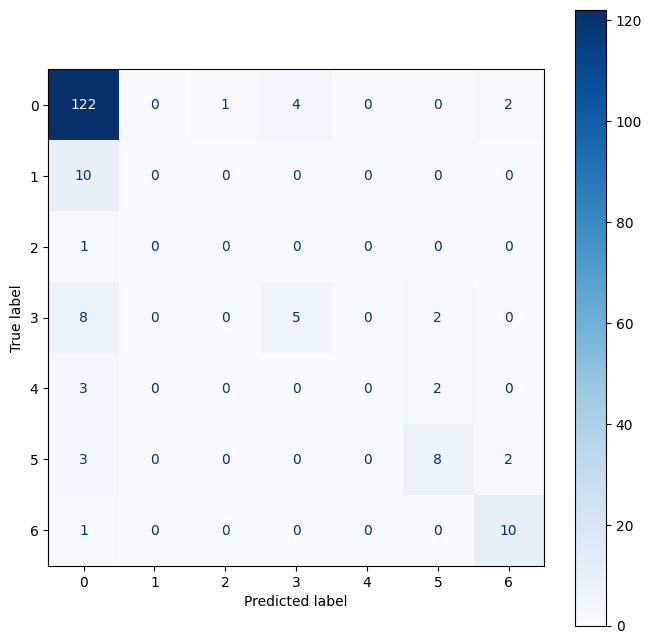

In [91]:
print('Матрица несоответствий метода "Градиентный бустинг":\n')
fig, ax = plt.subplots(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, grid_result.predict(x_test_lda)))
disp.plot(cmap = 'Blues', ax=ax);

clasification report

In [92]:
print ('\n clasification report:\n', classification_report(y_test, grid_result.predict(x_test_lda)))


 clasification report:
               precision    recall  f1-score   support

           0       0.82      0.95      0.88       129
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00         1
           3       0.56      0.33      0.42        15
           4       0.00      0.00      0.00         5
           5       0.67      0.62      0.64        13
           6       0.71      0.91      0.80        11

    accuracy                           0.79       184
   macro avg       0.39      0.40      0.39       184
weighted avg       0.71      0.79      0.74       184



f:\Anaconda\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
f:\Anaconda\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
f:\Anaconda\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## KNN

In [85]:
clf = KNeighborsClassifier()
par = {'n_neighbors': range(1, 15)}
search = GridSearchCV(clf, par,  scoring="f1_weighted", cv=5, n_jobs=-1)
search.fit(x_train_lda, y_train)
search.best_params_

{'n_neighbors': 3}

In [86]:
KNN_model = search.best_estimator_
KNN_model.fit(x_train_lda, y_train)
KNN_prediction = KNN_model.predict(x_test_lda)

KNN_train_accuracy = KNN_model.score(x_train_lda, y_train)
KNN_test_accuracy = KNN_model.score(x_test_lda, y_test)
print ('Точность модели на обучающей выборке: ', round (KNN_train_accuracy, 2))
print ('Точность модели на тестовой выборке: ', round (KNN_test_accuracy, 2))

Точность модели на обучающей выборке:  0.99
Точность модели на тестовой выборке:  0.8


Матрица несоответствий метода "KNN":



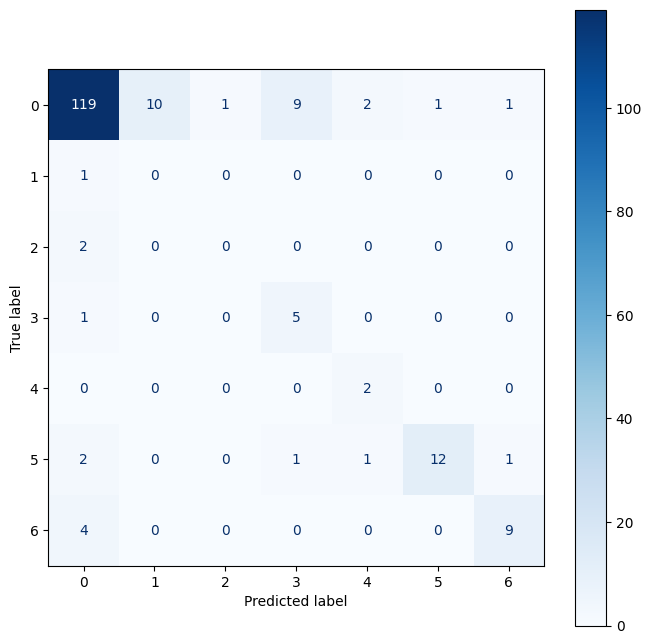

In [87]:
fig, ax = plt.subplots(figsize=(8, 8))
print('Матрица несоответствий метода "KNN":\n')
disp = ConfusionMatrixDisplay(confusion_matrix(KNN_prediction, y_test))
disp.plot(cmap = 'Blues', ax=ax);

clasification report

In [123]:
print ( classification_report(y_test, KNN_prediction))

              precision    recall  f1-score   support

           0       0.83      0.92      0.88       129
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00         1
           3       0.83      0.33      0.48        15
           4       1.00      0.40      0.57         5
           5       0.71      0.92      0.80        13
           6       0.69      0.82      0.75        11

    accuracy                           0.80       184
   macro avg       0.58      0.49      0.50       184
weighted avg       0.77      0.80      0.77       184



## Метод опорных векторов (SVM)

In [81]:
clf = SVC()
params = {'C': [1, 10, 100, 1000], 'gamma': [1, 0.1, 0.001, 0.0001], 'degree': range(1, 15), 'kernel': ['linear', 'rbf']}
search=GridSearchCV(clf, params, scoring="f1_weighted", cv=5, n_jobs=-1)
search.fit(x_train_lda, y_train)
search.best_params_

{'C': 1, 'degree': 1, 'gamma': 0.001, 'kernel': 'rbf'}

In [82]:
SVC_model = SVC(gamma='scale', kernel='poly', degree=1) 
SVC_model.fit(x_train_lda, y_train)
SVC_prediction = SVC_model.predict(x_test_lda) 

SVC_train_accuracy = SVC_model.score(x_train_lda, y_train)
SVC_test_accuracy = SVC_model.score(x_test_lda, y_test)
print ('Точность модели на обучающей выборке: ', round (SVC_train_accuracy, 2))
print ('Точность модели на тестовой выборке: ', round (SVC_test_accuracy, 2))

Точность модели на обучающей выборке:  0.99
Точность модели на тестовой выборке:  0.83


Матрица несоответствий метода опорных векторов:



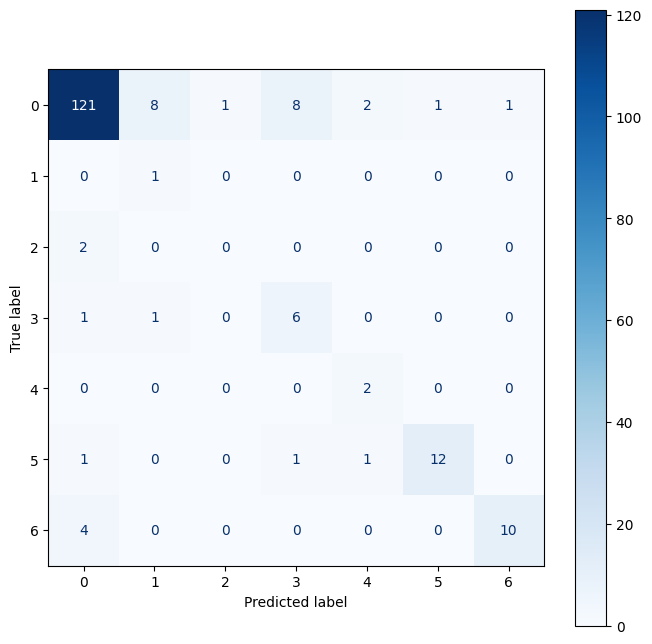

In [83]:
fig, ax = plt.subplots(figsize=(8, 8))
print('Матрица несоответствий метода опорных векторов:\n')
disp = ConfusionMatrixDisplay(confusion_matrix(SVC_prediction, y_test))
disp.plot(cmap = 'Blues', ax=ax);

clasification report

In [84]:
print ('\n clasification report:\n', classification_report(y_test, SVC_prediction))


 clasification report:
               precision    recall  f1-score   support

           0       0.85      0.94      0.89       129
           1       1.00      0.10      0.18        10
           2       0.00      0.00      0.00         1
           3       0.75      0.40      0.52        15
           4       1.00      0.40      0.57         5
           5       0.80      0.92      0.86        13
           6       0.71      0.91      0.80        11

    accuracy                           0.83       184
   macro avg       0.73      0.52      0.55       184
weighted avg       0.84      0.83      0.80       184



# Результаты

При учете метрик взвешенного среднего и f1 score лучше всего себя показал Метод Опорных Векторов (SVM) после снижения размерности с помощью PCA и LDA. Модель показала следующие результаты на тестовой выборке:

In [122]:
print ('Точность модели на обучающей выборке: ', round (SVC_train_accuracy, 4))
print ('Точность модели на тестовой выборке: ', round (SVC_test_accuracy, 4))

Точность модели на обучающей выборке:  0.9902
Точность модели на тестовой выборке:  0.8261


Матрица несоответствий метода опорных векторов:



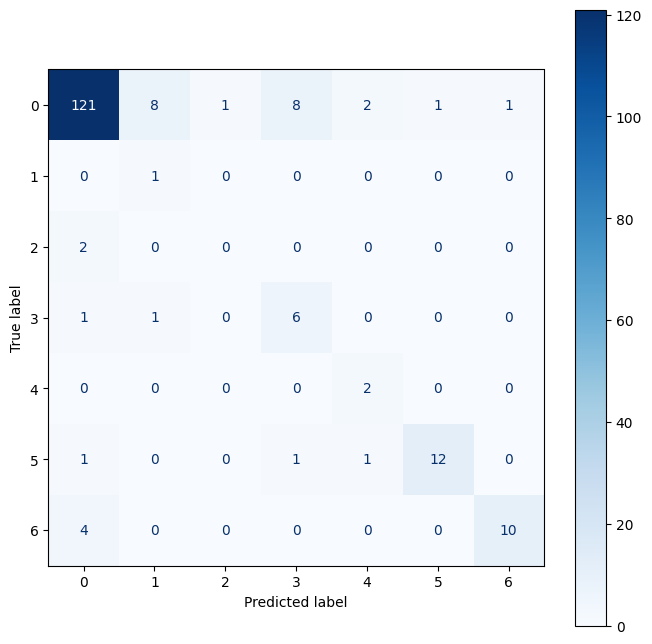

In [109]:
fig, ax = plt.subplots(figsize=(8, 8))
print('Матрица несоответствий метода опорных векторов:\n')
disp = ConfusionMatrixDisplay(confusion_matrix(SVC_prediction, y_test))
disp.plot(cmap = 'Blues', ax=ax);

In [121]:
print ('\n\t\t       Clasification report\n\n', classification_report(y_test, SVC_prediction))


		       Clasification report

               precision    recall  f1-score   support

           0       0.85      0.94      0.89       129
           1       1.00      0.10      0.18        10
           2       0.00      0.00      0.00         1
           3       0.75      0.40      0.52        15
           4       1.00      0.40      0.57         5
           5       0.80      0.92      0.86        13
           6       0.71      0.91      0.80        11

    accuracy                           0.83       184
   macro avg       0.73      0.52      0.55       184
weighted avg       0.84      0.83      0.80       184



Также неплохие результаты показала классификация с помощью LDA

In [124]:
print ('\n\t\t       Clasification report\n\n', classification_report(y_test, LDA_prediction))


		       Clasification report

               precision    recall  f1-score   support

           0       0.86      0.88      0.87       129
           1       0.33      0.10      0.15        10
           2       0.00      0.00      0.00         1
           3       0.69      0.60      0.64        15
           4       1.00      0.40      0.57         5
           5       0.75      0.92      0.83        13
           6       0.64      0.82      0.72        11

    accuracy                           0.80       184
   macro avg       0.61      0.53      0.54       184
weighted avg       0.79      0.80      0.79       184

